In [ ]:
!pip install torchbnn

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchbnn as bnn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Seismic/Copy of nga-east_rotd50_5pct_flatfile_public_20141118.xlsx"
df_org = pd.read_excel(path)

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
# Make device agnostic code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
df=df_org

df

,Record Sequence Number,EQID,Earthquake Name,Earthquake Location,Year,Month,Day,Hour,Minute,Earthquake Magnitude,...,T8.511363s,T8.709663s,T8.912497s,T9s,T9.120093s,T9.332537s,T9.5s,T9.549913s,T9.772401s,T10s
0,42,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,5.85,...,3.371480e-04,3.214520e-04,3.055400e-04,2.988270e-04,2.896760e-04,2.737270e-04,2.631590e-04,2.601610e-04,2.482690e-04,2.365760e-04
1,43,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,5.85,...,7.981870e-05,7.618600e-05,7.271660e-05,7.126930e-05,6.938110e-05,6.621790e-05,6.387290e-05,6.319790e-05,6.031420e-05,5.756260e-05
2,49,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,5.85,...,1.613400e-04,1.537930e-04,1.466720e-04,1.437700e-04,1.399400e-04,1.335270e-04,1.288400e-04,1.274950e-04,1.217690e-04,1.163280e-04
3,51,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,5.85,...,1.462360e-04,1.395990e-04,1.332670e-04,1.306680e-04,1.272240e-04,1.214550e-04,1.171800e-04,1.159490e-04,1.106930e-04,1.056780e-04
4,52,5,Saguenay_1988-11-25,Saguenay QC,1988,11,25,23,46,5.85,...,1.113560e-04,1.049390e-04,9.863450e-05,9.589730e-05,9.246470e-05,8.669810e-05,8.277760e-05,8.168850e-05,7.717850e-05,7.334710e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9377,12062,117,Saguenay_1988-11-26,Saguenay,1988,11,26,3,38,3.53,...,8.933050e-08,8.531680e-08,8.146960e-08,7.988330e-08,7.777390e-08,7.422510e-08,7.158480e-08,7.082370e-08,6.757090e-08,6.447040e-08
9378,12063,117,Saguenay_1988-11-26,Saguenay,1988,11,26,3,38,3.53,...,1.458760e-07,1.392980e-07,1.330240e-07,1.304630e-07,1.270800e-07,1.214380e-07,1.172640e-07,1.160620e-07,1.109160e-07,1.059250e-07
9379,12064,117,Saguenay_1988-11-26,Saguenay,1988,11,26,3,38,3.53,...,9.040710e-08,8.641220e-08,8.256080e-08,8.097280e-08,7.885820e-08,7.529330e-08,7.263440e-08,7.186690e-08,6.858680e-08,6.544350e-08
9380,12065,117,Saguenay_1988-11-26,Saguenay,1988,11,26,3,38,3.53,...,1.289430e-07,1.231820e-07,1.176900e-07,1.154530e-07,1.125070e-07,1.075390e-07,1.038150e-07,1.027360e-07,9.808450e-08,9.359120e-08


In [ ]:
# df = df.drop(df[df['ClstD (km)'] == -999 ].index)
# df = df.drop(df[df['Preferred VS30 (m/sec)'] == -999 ].index)
df = df.drop_duplicates()
# df = df.drop(df[df['Quality Flag Based on Ground Motions Residuals'] == -999 ].index)
# df = df.drop(df[df['Depth Used (km)'] == -999 ].index)
# df = df.drop(df[df['Hypocenter Depth (km)'] == -999 ].index)
df = df.drop(df[df['Joyner-Boore Dist. (km)'] == -999 ].index)
df = df.drop(df[df['Joyner-Boore Dist. (km)'] > 1500 ].index)
df = df.drop(df[df['PGA-H RotDnn (g)'] == -999 ].index)
# df = df.drop(df[df['Station Latitude (deg)'] == -999 ].index)
# df = df.drop(df[df['Station Longitude (deg)'] == -999 ].index)
# df = df.drop(df[df['Earthquake Magnitude'] < 0 ].index)
df = df.drop(df[df['HypD (km)'] <= 0 ].index)

In [ ]:
import joblib
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import sklearn.model_selection as sk

In [ ]:
df['Mw/Rjb'] = np.array(df['Earthquake Magnitude']) / np.array(df['Joyner-Boore Dist. (km)'])
df['log Rjb'] = np.log10(df['Joyner-Boore Dist. (km)'])

y = pd.DataFrame()
y['log PGA'] = np.log10(df['PGA-H RotDnn (g)'])
y['log PGV'] = np.log10(df['PGV-H RotDnn (cm/s)'])
t = [0.01 , 0.02 , 0.03 , 0.04 , 0.05,0.06 ,0.07 , 0.08 ,0.09,0.1,0.2 , 0.3 , 0.4, 0.5 ,0.6, 0.7,0.8,0.9,1,2,3,4,5]
for i in t:
    y[f"log PSA {i}s"] = np.log10(df[f"T{i}s"])

# X = df[['Earthquake Magnitude', 'Joyner-Boore Dist. (km)', 'log Rjb', 'Mw/Rjb', 'Mechanism Based on Rake Angle', 'Preferred VS30 (m/sec)']]
X = df[['Earthquake Magnitude', 'log Rjb', 'Preferred VS30 (m/sec)']]

X = X.values
y = y.values

x_train, x_test, y_train, y_test = sk.train_test_split(X, y, test_size = 0.15, random_state = 42)
x_test, x_val, y_test, y_val = sk.train_test_split(x_test, y_test, test_size = 0.5, random_state = 42)

In [ ]:
# path='Copy of BNN_Mixed effects_parameters (1)(1).xlsx'
# dataset = pd.read_excel(path)
# X = dataset.iloc[:, 0:6].values
# y = np.log10(dataset.iloc[:,8:].values)
# dataset.head()

In [ ]:
# #Printing shapes
# print(dataset.shape)
# print(X.shape)
# print(y.shape)

In [ ]:
#Converting X and y into torch tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

## Splitting the dataset into train and test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [ ]:
#Printing shapes
print(X_train.shape)
print(y_train.shape)

(6466, 3)
(6466, 25)


## Scaling the dataset using MinMax Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create the MinMaxScaler object
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test = scaler.transform(X_test)

In [ ]:
# Transform the test data using the same scaler
# X_test = scaler.transform(X_test)
X_test= pd.DataFrame(X_test)
X_train=pd.DataFrame(X_train)

In [ ]:
#Printing shapes
print("x_train shape:", X.shape)
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: torch.Size([8083, 3])
x_train shape: (6466, 3)
y_train shape: (6466, 25)
x_test shape: (1617, 3)
y_test shape: (1617, 25)


In [ ]:
# Access the underlying NumPy array using the values attribute
X_train_array = X_train.values

# Reshape the array to explicitly specify the shape
X_train_array = X_train_array.reshape(-1, 3)

# Convert the reshaped array into a PyTorch tensor
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)

# Access the underlying NumPy array using the values attribute
y_train_array = y_train.values

# Reshape the array to explicitly specify the shape
y_train_array = y_train_array.reshape(-1, 25)

# Convert the reshaped array into a PyTorch tensor
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)

In [ ]:
# Access the underlying NumPy array using the values attribute
X_test_array = X_test.values

# Reshape the array to explicitly specify the shape
X_test_array = X_test_array.reshape(-1, 3)

# Convert the reshaped array into a PyTorch tensor
X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)

# Access the underlying NumPy array using the values attribute
y_test_array = y_test.values

# Reshape the array to explicitly specify the shape
y_test_array = y_test_array.reshape(-1, 25)

# Convert the reshaped array into a PyTorch tensor
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

## Defining the Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.nn.init as init

# Custom prior function for standard Gaussian distribution
def sample_from_standard_gaussian_prior(shape):
    return torch.randn(shape)

# Custom Bayesian Linear layer with a prior function
class CustomBayesLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_fn):
        super(CustomBayesLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.prior_fn = prior_fn

        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features))

        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features))

        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight_mu)
        bound = 1 / math.sqrt(fan_in)

        init.uniform_(self.weight_mu, -bound, bound)
        init.uniform_(self.bias_mu, -bound, bound)

        nn.init.constant_(self.weight_rho, -5)  # Initialize log-variance with a small negative value
        nn.init.constant_(self.bias_rho, -5)

    def forward(self, x):
        # Sample weights and biases from the prior
        weight_epsilon = self.prior_fn(self.weight_mu.size())
        bias_epsilon = self.prior_fn(self.bias_mu.size())

        # Reparameterization trick for sampling
        weight_sample = self.weight_mu + torch.log(1 + torch.exp(self.weight_rho)) * weight_epsilon
        bias_sample = self.bias_mu + torch.log(1 + torch.exp(self.bias_rho)) * bias_epsilon

        # Compute output
        output = F.linear(x, weight_sample, bias_sample)

        return output

# Create your Bayesian neural network using the custom layer
model = nn.Sequential(
    CustomBayesLinear(in_features=3, out_features=12, prior_fn=sample_from_standard_gaussian_prior),
    nn.ELU(),
#     CustomBayesLinear(in_features=12, out_features=12, prior_fn=sample_from_standard_gaussian_prior),
#     nn.ELU(),
#     CustomBayesLinear(in_features=12, out_features=12, prior_fn=sample_from_standard_gaussian_prior),
#     nn.ELU(),
    CustomBayesLinear(in_features=12, out_features=25, prior_fn=sample_from_standard_gaussian_prior),
)

In [ ]:
y

tensor([[-0.8467,  0.7339, -0.8463,  ..., -2.3949, -2.7527, -2.9421],
        [-0.8783,  0.3580, -0.8880,  ..., -3.1725, -3.4346, -3.6373],
        [-1.0435,  0.5501, -1.0437,  ..., -2.7718, -3.0917, -3.3218],
        ...,
        [-3.5375, -2.2697, -3.5264,  ..., -6.1476, -6.3843, -6.5697],
        [-3.2689, -2.1203, -3.2515,  ..., -5.9765, -6.2346, -6.4257],
        [-3.4754, -2.2251, -3.4452,  ..., -5.9436, -6.2076, -6.4056]])

In [ ]:
# Reshape target_data to match the expected output shape of the model
y = y.view(-1, 25)  # Reshaping to [11675, 1]

In [ ]:
y

tensor([[-0.8467,  0.7339, -0.8463,  ..., -2.3949, -2.7527, -2.9421],
        [-0.8783,  0.3580, -0.8880,  ..., -3.1725, -3.4346, -3.6373],
        [-1.0435,  0.5501, -1.0437,  ..., -2.7718, -3.0917, -3.3218],
        ...,
        [-3.5375, -2.2697, -3.5264,  ..., -6.1476, -6.3843, -6.5697],
        [-3.2689, -2.1203, -3.2515,  ..., -5.9765, -6.2346, -6.4257],
        [-3.4754, -2.2251, -3.4452,  ..., -5.9436, -6.2076, -6.4056]])

In [ ]:
#Defining Loss and optimizer
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Optimizing the Model

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim

def predict_with_uncertainty(model, X_train_tensor, y_train_tensor, num_samples=100, num_steps=3000, kl_weight=0.01, lr=0.01):
    # Define loss function and optimizer
    mse_loss = torch.nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    predictions = []
    for _ in range(num_samples):
        for step in range(num_steps):
            # Forward pass
            pre1 = model(X_train_tensor)

            # Compute loss
            mse = mse_loss(pre1, y_train_tensor)
            kl = kl_loss(model)
            cost = mse + kl_weight * kl

            # Backpropagation and optimization
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()

        predictions.append(pre1.unsqueeze(0))  # Add batch dimension

        # Save the state dictionary of the optimized model
        torch.save(model.state_dict(), f'optimized_model_Final{_}.pth')
#         print(model.state_dict())

    predictions = torch.cat(predictions, dim=0)  # Shape: (num_samples, batch_size, num_classes)

    # Calculate mean prediction, aleatoric uncertainty, and epistemic uncertainty
    mean_prediction = torch.mean(predictions, dim=0)
#     median_prediction = torch.median(predictions, dim=0)
    #epistemic_std = torch.std(mean_prediction, dim=0)  # Uncertainty due to model parameter uncertainty
#     epistemic_std = torch.mean(torch.std(predictions, dim=0),dim=0)  # Uncertainty due to noise in the data

    return predictions,mean_prediction

## Predictions

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/Seismic/BNN/Best model/best_model.pth"

model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
# predictions, mean_prediction = predict_with_uncertainty(model, X_train_tensor, y_train_tensor, num_steps=20000)

In [ ]:
predictions_train = []
num_samples = 100

for i in range(num_samples):
  predictions_train.append(model(X_train_tensor).unsqueeze(0))

predictions_train = torch.cat(predictions_train, dim=0)
mean_prediction_train = torch.mean(predictions_train, dim=0)

In [ ]:
# OPTIMIZED_MODEL_FINAL_PATH = "/content/drive/MyDrive/Seismic/BNN/Optimized Paths/"

# for i in range(100):
#   model.load_state_dict(torch.load(f'optimized_model_Final{i}.pth'))
#   torch.save(model.state_dict(), f'{OPTIMIZED_MODEL_FINAL_PATH}optimized_model_Final{i}.pth')

# torch.save(model.state_dict(), MODEL_PATH)

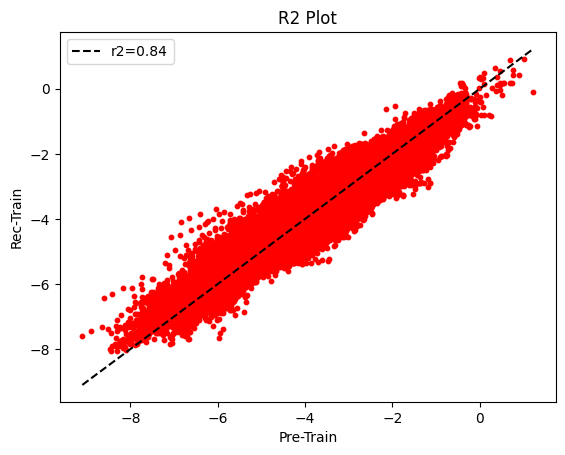

In [ ]:
plt.xlabel(r'$y-rec$')
plt.ylabel(r'$y-pred$')

#plt.scatter(X_test.data.numpy(), y_test.data.numpy(), color='k', s=2)
#serial =  range(0,37)
# serial = 20
# XX = y_train_tensor[:, serial].data.numpy()
XX = y_train
YY = mean_prediction_train
# YY = mean_prediction[:, ser

plt.scatter(XX, YY.detach().numpy(), color='r', s=10)

#plt.scatter( y_test,y_predict.data.numpy(), color='r', s=10)

min_val = min(np.min(XX), np.min(YY.detach().numpy()))
max_val = max(np.max(XX), np.max(YY.detach().numpy()))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='r2=0.84')

plt.title('R2 Plot')
plt.ylabel('Rec-Train')
plt.xlabel('Pre-Train')
plt.legend()

plt.show()


In [ ]:
predictions_test = []
num_samples = 100

for i in range(num_samples):
  predictions_test.append(model(X_test_tensor).unsqueeze(0))

predictions_test = torch.cat(predictions_test, dim=0)
mean_prediction_test = torch.mean(predictions_test, dim=0)

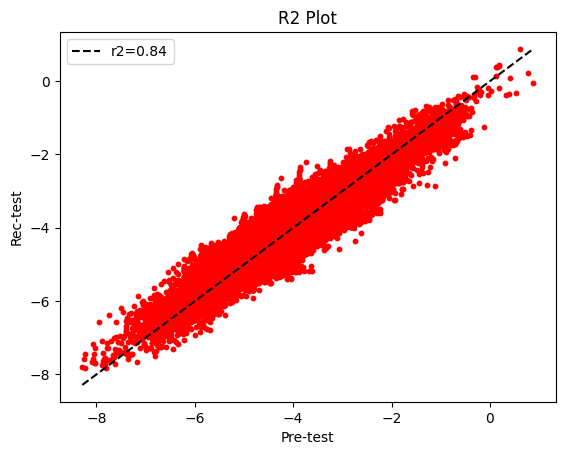

In [ ]:
plt.xlabel(r'$y-rec$')
plt.ylabel(r'$y-pred$')

#plt.scatter(X_test.data.numpy(), y_test.data.numpy(), color='k', s=2)
#serial =  range(0,37)
# serial = 20
# XX = y_test_tensor[:, serial].data.numpy()
XX = y_test
YY = mean_prediction_test
# YY = mean_prediction[:, ser

plt.scatter(XX, YY.detach().numpy(), color='r', s=10)

#plt.scatter( y_test,y_predict.data.numpy(), color='r', s=10)

min_val = min(np.min(XX), np.min(YY.detach().numpy()))
max_val = max(np.max(XX), np.max(YY.detach().numpy()))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='r2=0.84')

plt.title('R2 Plot')
plt.ylabel('Rec-test')
plt.xlabel('Pre-test')
plt.legend()

plt.show()

In [ ]:
predictions_test = []
num_samples = 100

for i in range(num_samples):
  predictions_test.append(model(X_test_tensor).unsqueeze(0))

predictions_test = torch.cat(predictions_test, dim=0)
mean_prediction_test = torch.mean(predictions_test, dim=0)

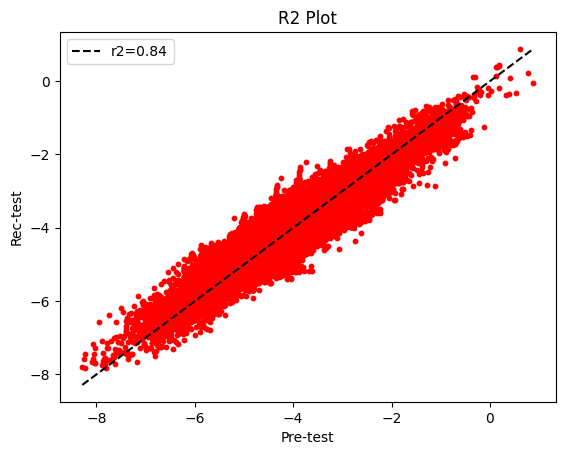

In [ ]:
plt.xlabel(r'$y-rec$')
plt.ylabel(r'$y-pred$')

#plt.scatter(X_test.data.numpy(), y_test.data.numpy(), color='k', s=2)
#serial =  range(0,37)
# serial = 20
# XX = y_test_tensor[:, serial].data.numpy()
XX = y_test
YY = mean_prediction_test
# YY = mean_prediction[:, ser

plt.scatter(XX, YY.detach().numpy(), color='r', s=10)

#plt.scatter( y_test,y_predict.data.numpy(), color='r', s=10)

min_val = min(np.min(XX), np.min(YY.detach().numpy()))
max_val = max(np.max(XX), np.max(YY.detach().numpy()))
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='r2=0.84')

plt.title('R2 Plot')
plt.ylabel('Rec-test')
plt.xlabel('Pre-test')
plt.legend()

plt.show()

In [ ]:
serial = range(0,74)
# xx = y_train_tensor[:, serial].data.numpy()
xx = y_train
yy = mean_prediction_train
# yy = mean_prediction[:, serial]

In [ ]:
#Calculating R2 square for each time period
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

xx_transposed = np.transpose(xx)
yy_transposed = np.transpose(yy.detach().numpy())

r_squared_values = []
for i in range(len(xx_transposed)):
  r_squared = r2_score(xx[i], yy_transposed[i])
  r_squared_values.append(r_squared)

rounded_values = [round(value, 2) for value in r_squared_values]

print(rounded_values)
print(np.array(rounded_values).mean())

[0.85, 0.86, 0.85, 0.85, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.83, 0.83, 0.83, 0.82, 0.82, 0.81, 0.82, 0.82, 0.83, 0.83, 0.84, 0.86, 0.87, 0.85, 0.83]
0.8375999999999999


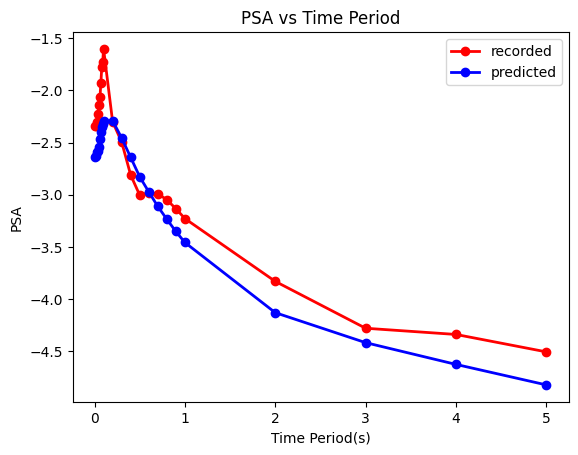

In [ ]:
#Plotting a single datapoint
import matplotlib.pyplot as plt
# zz = predictions.mean(axis=(0,1))
# true_mean = true.detach().numpy().mean(axis=(0,1))

prediction_64 = []

for i in predictions_train:
  prediction_64.append(i.detach().numpy()[64])

prediction_64 = np.array(prediction_64)
prediction_64 = prediction_64.mean(axis=0)
y_train_64 = np.transpose(np.array(y_train)[64])

plt.xlabel('Time Period(s)')
plt.ylabel('PSA')
plt.title('PSA vs Time Period')

plt.plot(t, y_train_64[2:], '-o', label='recorded', linewidth = 2, color ='Red')
plt.plot(t, prediction_64[2:], '-o', label='predicted', linewidth = 2, color ='Blue')
plt.legend()

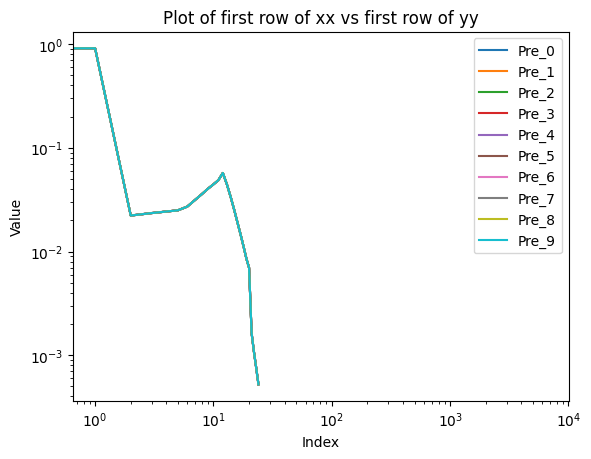

In [ ]:
#Plotting a single datapoint
import matplotlib.pyplot as plt
zz = predictions_train
num_step = 10
for _ in range(num_step):
    plt.plot(np.power(10,zz[_][10].detach().numpy()), label=f'Pre_{_}')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Plot of first row of xx vs first row of yy')
    plt.legend()
plt.plot(xx[10], label='rec',linewidth = 3,color ='black')

In [ ]:
X_plot = pd.DataFrame(columns = ['Mw', 'logRjb', 'Vs30'])

X_plot.loc[0] = [3, math.log10(10), 760]
X_plot.loc[1] = [4, math.log10(10), 760]
X_plot.loc[2] = [5, math.log10(10), 760]
X_plot.loc[3] = [6, math.log10(10), 760]
X_plot.loc[4] = [7, math.log10(10), 760]
X_plot.loc[5] = [8, math.log10(10), 760]

X_plot = scaler.transform(X_plot)
X_plot = torch.tensor(X_plot, dtype=torch.float32)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
# multi_predictions_0 = []
# multi_predictions_1 = []
# multi_predictions_2 = []

# for i in range(1000):
#   predictions = model(X_plot)
#   multi_predictions_0.append(predictions.detach().numpy()[0])
#   multi_predictions_1.append(predictions.detach().numpy()[1])
#   multi_predictions_2.append(predictions.detach().numpy()[2])

# pred_value_0 = np.array(multi_predictions_0).mean(axis=0)
# pred_value_1 = np.array(multi_predictions_1).mean(axis=0)
# pred_value_2 = np.array(multi_predictions_2).mean(axis=0)

# pred_value_0 = np.power(10, pred_value_0)
# pred_value_1 = np.power(10, pred_value_1)
# pred_value_2 = np.power(10, pred_value_2)

In [ ]:
dict_ = {0:'d', 1:'s', 2:'^', 3:'*', 4:'o', 5:'+'}

In [ ]:
multi_predictions = [[], [], [], [], [], []]
pred_value = [[], [], [], [], [], []]

for i in range(1000):
  predictions = model(X_plot)
  for j in range(6):
    multi_predictions[j].append(predictions.detach().numpy()[j])

for i in range(6):
  pred_value[i] = np.array(multi_predictions[i]).mean(axis=0)
  pred_value[i] = np.power(10, pred_value[i])

Text(0, 0.5, 'PSA(g)')

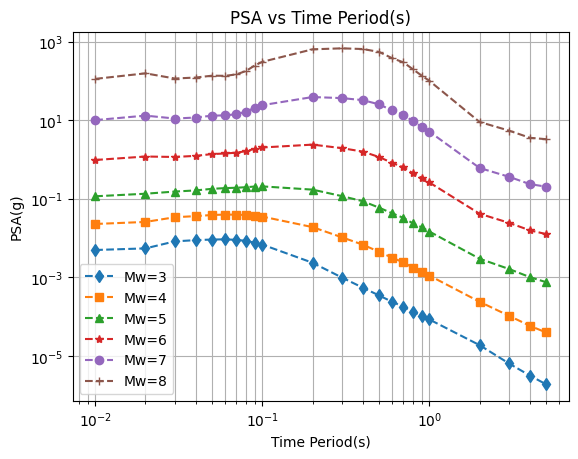

In [ ]:
for i in range(6):
  plt.plot(t, pred_value[i][2:], linestyle='--', marker = dict_[i], label=f"Mw={i+3}")

plt.grid(True, which="both")
plt.xscale('log')
plt.yscale('log')

plt.legend(loc="lower left")
plt.title("PSA vs Time Period(s)")
plt.xlabel("Time Period(s)")
plt.ylabel("PSA(g)")

In [ ]:
X_plot = pd.DataFrame(columns = ['Mw', 'logRjb', 'Vs30'])
R=[50,100,150,200,250,300,350]

X_plot.loc[0] = [5, math.log10(50), 760]
X_plot.loc[1] = [5, math.log10(100), 760]
X_plot.loc[2] = [5, math.log10(150), 760]
X_plot.loc[3] = [5, math.log10(250), 760]
X_plot.loc[4] = [5, math.log10(300), 760]
X_plot.loc[5] = [5, math.log10(350), 760]

X_plot = scaler.transform(X_plot)
X_plot = torch.tensor(X_plot, dtype=torch.float32)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
multi_predictions = [[], [], [], [], [], []]
pred_value = [[], [], [], [], [], []]

for i in range(1000):
  predictions = model(X_plot)
  for j in range(6):
    multi_predictions[j].append(predictions.detach().numpy()[j])

for i in range(6):
  pred_value[i] = np.array(multi_predictions[i]).mean(axis=0)
  pred_value[i] = np.power(10, pred_value[i])

Text(0, 0.5, 'PSA(g)')

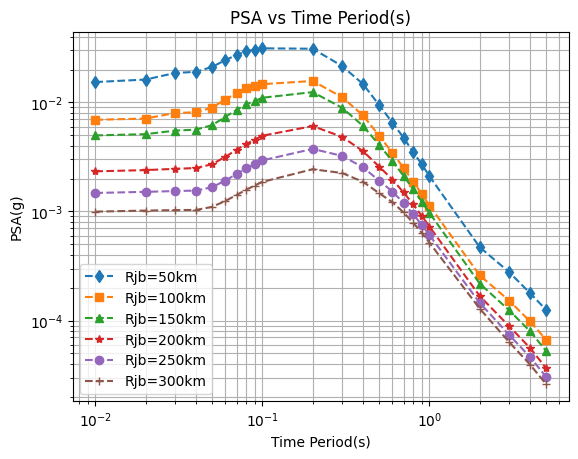

In [ ]:
for i in range(6):
  plt.plot(t, pred_value[i][2:], linestyle='--', marker = dict_[i], label=f"Rjb={R[i]}km")

plt.grid(True, which="both")
plt.xscale('log')
plt.yscale('log')

plt.legend(loc="lower left")
plt.title("PSA vs Time Period(s)")
plt.xlabel("Time Period(s)")
plt.ylabel("PSA(g)")

In [ ]:
X_plot = pd.DataFrame(columns = ['Mw', 'logRjb', 'Vs30'])
V=[480,760,1080,1240,1560,1800]

# X_plot.loc[0] = [5, math.log10(100), 240]
# X_plot.loc[0] = [5, math.log10(100), 480]
X_plot.loc[0] = [5, math.log10(100), 760]
X_plot.loc[1] = [5, math.log10(100), 1080]
X_plot.loc[2] = [5, math.log10(100), 1240]
X_plot.loc[3] = [5, math.log10(100), 1560]

X_plot = scaler.transform(X_plot)
X_plot = torch.tensor(X_plot, dtype=torch.float32)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [ ]:
multi_predictions = [[], [], [], [], [], []]
pred_value = [[], [], [], [], [], []]

for i in range(1000):
  predictions = model(X_plot)
  for j in range(4):
    multi_predictions[j].append(predictions.detach().numpy()[j])

for i in range(4):
  pred_value[i] = np.array(multi_predictions[i]).mean(axis=0)
  pred_value[i] = np.power(10, pred_value[i])

Text(0, 0.5, 'PSA(g)')

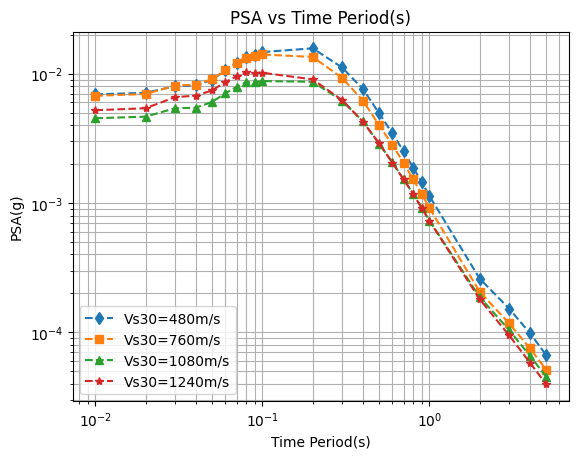

In [ ]:
for i in range(4):
  plt.plot(t, pred_value[i][2:], linestyle='--', marker = dict_[i], label=f"Vs30={V[i]}m/s")

plt.grid(True, which="both")
plt.xscale('log')
plt.yscale('log')

plt.legend(loc="lower left")
plt.title("PSA vs Time Period(s)")
plt.xlabel("Time Period(s)")
plt.ylabel("PSA(g)")